In [7]:
import os
import importlib
import numpy as np
import tensorflow as tf

import texar as tx
from texar.tf.modules import WordEmbedder, UnidirectionalRNNEncoder, \
        MLPTransformConnector, AttentionRNNDecoder, \
        GumbelSoftmaxEmbeddingHelper, Conv1DClassifier
from texar.tf.core import get_train_op
from texar.tf.utils import collect_trainable_variables, get_batch_size

from texar.tf.data import MultiAlignedData, FeedableDataIterator

from texar import HParams

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import copy

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import csv

In [8]:
config = {
    'max_nepochs': 15, # Total number of training epochs
                 # (including pre-train and full-train)
    'pretrain_ae_nepochs': 10, # Number of pre-train epochs (training as autoencoder)
    'display': 500,  # Display the training results every N training steps.
    'display_eval': 1e10, # Display the dev results every N training steps (set to a
                    # very large value to disable it).
    'sample_path': './samples',
    'checkpoint_path': './checkpoints',
    'restore': '',   # Model snapshot to restore from

    'lambda_g': 0.1,    # Weight of the classification loss
    'lambda_z': 0.5,
    'lambda_z1': 3000.,
    'lambda_z2': 3000.,
    'gamma_decay': 0.5,   # Gumbel-softmax temperature anneal rate

    'change_lambda_ae': 0.,
    'change_lambda_ae_epoch': 12,

    'plot_z': True,
    'plot_max_count': 1000,

    'spam': True,
    'repetitions': True,

    'write_text': True,
    'write_labels': True,

    'manual': True,

    'train_data': {
        'batch_size': 64,
        # "max_dataset_size": 256,
        #'seed': 123,
        'datasets': [
            {
                'files': './data/yelp/sentiment.train.text',
                'vocab_file': './data/yelp/vocab',
                'data_name': ''
            },
            {
                'files': './data/yelp/sentiment.train.labels',
                'data_type': 'int',
                'data_name': 'labels'
            }
        ],
        'name': 'train'
    }
}

config['val_data'] = copy.deepcopy(config['train_data'])
config['val_data']['datasets'][0]['files'] = './data/yelp/sentiment.dev.text'
config['val_data']['datasets'][1]['files'] = './data/yelp/sentiment.dev.labels'

config['test_data'] = copy.deepcopy(config['train_data'])
config['test_data']['datasets'][0]['files'] = './data/yelp/sentiment.test.text'
config['test_data']['datasets'][1]['files'] = './data/yelp/sentiment.test.labels'

if config['manual']:
    config['manual_data'] = copy.deepcopy(config['train_data'])
    config['manual_data']['datasets'][0]['files'] = './data/yelp/sentiment.manual.text'
    config['manual_data']['datasets'][1]['files'] = './data/yelp/sentiment.manual.labels'

model_dict = {
    'dim_c': 200,
    'dim_z': 500,
    'num_classes': 2,
    'embedder': {
        'dim': 100,
    },
    'encoder': {
        'rnn_cell': {
            'type': 'GRUCell',
            'kwargs': {
                'num_units': 700
            },
            'dropout': {
                'input_keep_prob': 0.5
            }
        }
    },
    'decoder': {
        'rnn_cell': {
            'type': 'GRUCell',
            'kwargs': {
                'num_units': 700,
            },
            'dropout': {
                'input_keep_prob': 0.5,
                'output_keep_prob': 0.5
            },
        },
        'attention': {
            'type': 'BahdanauAttention',
            'kwargs': {
                'num_units': 700,
            },
            'attention_layer_size': 700,
        },
        'max_decoding_length_train': 21,
        'max_decoding_length_infer': 20,
    },
    'classifier': {
        'kernel_size': [3, 4, 5],
        'filters': 128,
        'other_conv_kwargs': {'padding': 'same'},
        'dropout_conv': [1],
        'dropout_rate': 0.5,
        'num_dense_layers': 0,
        'num_classes': 1
    },
    'opt': {
        'optimizer': {
            'type':  'AdamOptimizer',
            'kwargs': {
                'learning_rate': 5e-4,
            },
        },
    },
    'z_classifier_l1': {
        'activation_fn': 'sigmoid'
    },
    'z_classifier_l2': {
        'activation_fn': 'sigmoid'
    }
}

In [9]:
class CtrlGenModel(object):

    def __init__(self, inputs, vocab, gamma, lambda_g, lambda_z, lambda_z1, lambda_z2, lambda_ae, hparams=None):
        self._hparams = tx.HParams(hparams, None)
        self._build_model(inputs, vocab, gamma, lambda_g, lambda_z, lambda_z1, lambda_z2, lambda_ae)


    def _build_model(self, inputs, vocab, gamma, lambda_g, lambda_z, lambda_z1, lambda_z2, lambda_ae):

        embedder = WordEmbedder(
            vocab_size=vocab.size,
            hparams=self._hparams.embedder)

        encoder = UnidirectionalRNNEncoder(hparams=self._hparams.encoder)

        enc_text_ids = inputs['text_ids'][:, 1:]
        enc_outputs, final_state = encoder(embedder(enc_text_ids),
                                           sequence_length=inputs['length']-1)

        z = final_state[:, self._hparams.dim_c:]

        # -------------------- CLASSIFIER ---------------------

        n_classes = self._hparams.num_classes
        z_classifier_l1 = MLPTransformConnector(256, hparams=self._hparams.z_classifier_l1)
        z_classifier_l2 = MLPTransformConnector(64, hparams=self._hparams.z_classifier_l2)
        z_classifier_out = MLPTransformConnector(n_classes if n_classes > 2 else 1)

        z_logits = z_classifier_l1(z)
        z_logits = z_classifier_l2(z_logits)
        z_logits = z_classifier_out(z_logits)
        z_pred = tf.greater(z_logits, 0)
        z_logits = tf.reshape(z_logits, [-1])

        z_pred = tf.to_int64(tf.reshape(z_pred, [-1]))

        loss_z_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(inputs['labels']), logits=z_logits)
        loss_z_clas = tf.reduce_mean(loss_z_clas)

        accu_z_clas = tx.evals.accuracy(labels=inputs['labels'], preds=z_pred)

        # -------------------________________---------------------


        label_connector = MLPTransformConnector(self._hparams.dim_c)

        labels = tf.to_float(tf.reshape(inputs['labels'], [-1, 1]))

        c = label_connector(labels)
        c_ = label_connector(1 - labels)

        h = tf.concat([c, z], 1)
        h_ = tf.concat([c_, z], 1)

        # Teacher-force decoding and the auto-encoding loss for G

        decoder = AttentionRNNDecoder(
            memory=enc_outputs,
            memory_sequence_length=inputs['length']-1,
            cell_input_fn=lambda inputs, attention: inputs,
            vocab_size=vocab.size,
            hparams=self._hparams.decoder)

        connector = MLPTransformConnector(decoder.state_size)

        g_outputs, _, _ = decoder(
            initial_state=connector(h), inputs=inputs['text_ids'],
            embedding=embedder, sequence_length=inputs['length']-1)

        loss_g_ae = tx.losses.sequence_sparse_softmax_cross_entropy(
            labels=inputs['text_ids'][:, 1:],
            logits=g_outputs.logits,
            sequence_length=inputs['length']-1,
            average_across_timesteps=True,
            sum_over_timesteps=False)

        # Gumbel-softmax decoding, used in training

        start_tokens = tf.ones_like(inputs['labels']) * vocab.bos_token_id

        end_token = vocab.eos_token_id

        gumbel_helper = GumbelSoftmaxEmbeddingHelper(
            embedder.embedding, start_tokens, end_token, gamma)

        soft_outputs_, _, soft_length_, = decoder(
            helper=gumbel_helper, initial_state=connector(h_))

        soft_outputs, _, soft_length, = decoder(
            helper=gumbel_helper, initial_state=connector(h))


        # ---------------------------- SHIFTED LOSS -------------------------------------
        _, encoder_final_state_ = encoder(embedder(soft_ids=soft_outputs_.sample_id),
                                          sequence_length=inputs['length'] - 1)
        _, encoder_final_state = encoder(embedder(soft_ids=soft_outputs.sample_id),
                                         sequence_length=inputs['length'] - 1)
        new_z_ = encoder_final_state_[:, self._hparams.dim_c:]
        new_z = encoder_final_state[:, self._hparams.dim_c:]

        cos_distance_z_ = tf.abs(
            tf.losses.cosine_distance(tf.nn.l2_normalize(z, axis=1), tf.nn.l2_normalize(new_z_, axis=1), axis=1))
        cos_distance_z = tf.abs(
            tf.losses.cosine_distance(tf.nn.l2_normalize(z, axis=1), tf.nn.l2_normalize(new_z, axis=1), axis=1))
        # ----------------------------______________-------------------------------------


        # Greedy decoding, used in eval

        outputs_, _, length_ = decoder(
            decoding_strategy='infer_greedy', initial_state=connector(h_),
            embedding=embedder, start_tokens=start_tokens, end_token=end_token)

        # Creates classifier

        classifier = Conv1DClassifier(hparams=self._hparams.classifier)

        clas_embedder = WordEmbedder(vocab_size=vocab.size,
                                     hparams=self._hparams.embedder)

        # Classification loss for the classifier

        clas_logits, clas_preds = classifier(
            inputs=clas_embedder(ids=inputs['text_ids'][:, 1:]),
            sequence_length=inputs['length']-1)

        loss_d_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(inputs['labels']), logits=clas_logits)

        loss_d_clas = tf.reduce_mean(loss_d_clas)

        accu_d = tx.evals.accuracy(labels=inputs['labels'], preds=clas_preds)

        # Classification loss for the generator, based on soft samples

        soft_logits, soft_preds = classifier(
            inputs=clas_embedder(soft_ids=soft_outputs_.sample_id),
            sequence_length=soft_length_)

        loss_g_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(1-inputs['labels']), logits=soft_logits)

        loss_g_clas = tf.reduce_mean(loss_g_clas)

        # Accuracy on soft samples, for training progress monitoring

        accu_g = tx.evals.accuracy(labels=1-inputs['labels'], preds=soft_preds)

        # Accuracy on greedy-decoded samples, for training progress monitoring

        _, gdy_preds = classifier(
            inputs=clas_embedder(ids=outputs_.sample_id),
            sequence_length=length_)

        accu_g_gdy = tx.evals.accuracy(
            labels=1-inputs['labels'], preds=gdy_preds)

        # Aggregates losses

        loss_g = lambda_ae * loss_g_ae + \
                 lambda_g * loss_g_clas + \
                 lambda_z1 * cos_distance_z + cos_distance_z_ * lambda_z2 \
                 - lambda_z * loss_z_clas
        loss_d = loss_d_clas
        loss_z = loss_z_clas

        # Creates optimizers

        g_vars = collect_trainable_variables(
            [embedder, encoder, label_connector, connector, decoder])
        d_vars = collect_trainable_variables([clas_embedder, classifier])
        z_vars = collect_trainable_variables([z_classifier_l1, z_classifier_l2, z_classifier_out])

        train_op_g = get_train_op(
            loss_g, g_vars, hparams=self._hparams.opt)
        train_op_g_ae = get_train_op(
            loss_g_ae, g_vars, hparams=self._hparams.opt)
        train_op_d = get_train_op(
            loss_d, d_vars, hparams=self._hparams.opt)
        train_op_z = get_train_op(
            loss_z, z_vars, hparams=self._hparams.opt
        )

        # Interface tensors
        self.losses = {
            "loss_g": loss_g,
            "loss_g_ae": loss_g_ae,
            "loss_g_clas": loss_g_clas,
            "loss_d": loss_d_clas,
            "loss_z_clas": loss_z_clas,
            "loss_cos_": cos_distance_z_,
            "loss_cos": cos_distance_z
        }
        self.metrics = {
            "accu_d": accu_d,
            "accu_g": accu_g,
            "accu_g_gdy": accu_g_gdy,
            "accu_z_clas": accu_z_clas
        }
        self.train_ops = {
            "train_op_g": train_op_g,
            "train_op_g_ae": train_op_g_ae,
            "train_op_d": train_op_d,
            "train_op_z": train_op_z
        }
        self.samples = {
            "original": inputs['text_ids'][:, 1:],
            "transferred": outputs_.sample_id,
            "z_vector": z,
            "labels_source": inputs['labels'],
            "labels_target": 1 - inputs['labels'],
            "labels_predicted": gdy_preds
        }

        self.fetches_train_g = {
            "loss_g": self.train_ops["train_op_g"],
            "loss_g_ae": self.losses["loss_g_ae"],
            "loss_g_clas": self.losses["loss_g_clas"],
            "loss_shifted_ae1": self.losses["loss_cos"],
            "loss_shifted_ae2": self.losses["loss_cos_"],
            "accu_g": self.metrics["accu_g"],
            "accu_g_gdy": self.metrics["accu_g_gdy"],
            "accu_z_clas": self.metrics["accu_z_clas"]
        }

        self.fetches_train_z = {
            "loss_z": self.train_ops["train_op_z"],
            "accu_z": self.metrics["accu_z_clas"]
        }

        self.fetches_train_d = {
            "loss_d": self.train_ops["train_op_d"],
            "accu_d": self.metrics["accu_d"]
        }
        fetches_eval = {"batch_size": get_batch_size(inputs['text_ids'])}
        fetches_eval.update(self.losses)
        fetches_eval.update(self.metrics)
        fetches_eval.update(self.samples)
        self.fetches_eval = fetches_eval

In [10]:
def train_model():
    # Data
    train_data = MultiAlignedData(config['train_data'])
    val_data = MultiAlignedData(config['val_data'])
    test_data = MultiAlignedData(config['test_data'])
    if config['manual']:
        manual_data = MultiAlignedData(config['manual_data'])
    vocab = train_data.vocab(0)

    # Each training batch is used twice: once for updating the generator and
    # once for updating the discriminator. Feedable data iterator is used for
    # such case.
    if config['manual']:
        iterator = tx.data.FeedableDataIterator(
            {'train_g': train_data, 'train_d': train_data, 'train_z': train_data,
             'val': val_data, 'test': test_data, 'manual': manual_data})
    else:
        iterator = tx.data.FeedableDataIterator(
            {'train_g': train_data, 'train_d': train_data, 'train_z': train_data,
             'val': val_data, 'test': test_data})
    batch = iterator.get_next()

    # Model
    gamma = tf.placeholder(dtype=tf.float32, shape=[], name='gamma')
    lambda_g = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_g')
    lambda_z = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_z')
    lambda_z1 = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_z1')
    lambda_z2 = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_z2')
    lambda_ae = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_ae')
    model = CtrlGenModel(batch, vocab, gamma, lambda_g, lambda_z, lambda_z1, lambda_z2, lambda_ae, model_dict)
    
    def _train_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, verbose=True):
        avg_meters_d = tx.utils.AverageRecorder(size=10)
        avg_meters_g = tx.utils.AverageRecorder(size=10)
        avg_meters_z = tx.utils.AverageRecorder(size=10)

        step = 0
        while True:
            try:
                step += 1
                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_d'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_z1: lambda_z1_,
                    lambda_z2: lambda_z2_,
                    lambda_ae: lambda_ae_
                }

                vals_d = sess.run(model.fetches_train_d, feed_dict=feed_dict)
                avg_meters_d.add(vals_d)

                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_g'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_z1: lambda_z1_,
                    lambda_z2: lambda_z2_,
                    lambda_ae: lambda_ae_
                }
                vals_g = sess.run(model.fetches_train_g, feed_dict=feed_dict)
                avg_meters_g.add(vals_g)

                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_z'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_z1: lambda_z1_,
                    lambda_z2: lambda_z2_,
                    lambda_ae: lambda_ae_
                }
                vals_z = sess.run(model.fetches_train_z, feed_dict=feed_dict)
                avg_meters_z.add(vals_z)


                if verbose and (step == 1 or step % config['display'] == 0):
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_d.to_str(4)))
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_z.to_str(4)))
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_g.to_str(4)))

                if verbose and step % config['display_eval'] == 0:
                    iterator.restart_dataset(sess, 'val')
                    _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_z1_, lambda_z2_, lambda_ae_, epoch)

            except tf.errors.OutOfRangeError:
                print('epoch: {}, {}'.format(epoch, avg_meters_d.to_str(4)))
                print('epoch: {}, {}'.format(epoch, avg_meters_z.to_str(4)))
                print('epoch: {}, {}'.format(epoch, avg_meters_g.to_str(4)))
                break

    def _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_z1_,lambda_z2_, lambda_ae_, epoch, val_or_test='val',
                    plot_z=False, plot_max_count=1000, spam=False, repetitions=False, write_text=True,
                    write_labels=False):
        avg_meters = tx.utils.AverageRecorder()

        if plot_z:
            z_vectors = []
            labels = []
            tsne = TSNE(n_components=2)
        while True:
            try:
                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, val_or_test),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_z1: lambda_z1_,
                    lambda_z2: lambda_z2_,
                    lambda_ae: lambda_ae_,
                    tx.context.global_mode(): tf.estimator.ModeKeys.EVAL
                }

                vals = sess.run(model.fetches_eval, feed_dict=feed_dict)

                batch_size = vals.pop('batch_size')

                # Computes BLEU
                samples = tx.utils.dict_pop(vals, list(model.samples.keys()))
                hyps = tx.utils.map_ids_to_strs(samples['transferred'], vocab)

                refs = tx.utils.map_ids_to_strs(samples['original'], vocab)
                refs = np.expand_dims(refs, axis=1)

                bleu = tx.evals.corpus_bleu_moses(refs, hyps)
                vals['bleu'] = bleu

                if spam or repetitions:
                    target_labels = samples['labels_target']
                    predicted_labels = samples['labels_predicted']

                    results = [(r, h, t, p) for r, h, t, p in zip(refs, hyps, target_labels, predicted_labels)]

                # Computes repetitions
                if repetitions:
                    count_equal_strings = 0
                    remain_samples_e = []
                    for r, h, t, p in results:
                        if r == h:
                            count_equal_strings += 1
                        else:
                            remain_samples_e.append((r, h, t, p))
                    vals['equal'] = count_equal_strings / len(hyps)

                # Computes spam
                if spam:
                    count_spam = 0
                    remain_samples_s = []
                    for r, h, t, p in results:
                        words = h.split()
                        if len(words) > 2 and words[-1] == words[-2]:
                            count_spam += 1
                        elif len(words) > 4 and words[-1] == words[-3] and words[-2] == words[-4]:
                            count_spam += 1
                        else:
                            remain_samples_s.append((r, h, t, p))
                    vals['spam'] = count_spam / len(hyps)

                if repetitions and spam:
                    remain_samples = [sample for sample in remain_samples_e if sample in remain_samples_s]
                    remain_samples = list(remain_samples)
                elif not repetitions and spam:
                    remain_samples = remain_samples_s
                elif repetitions and not spam:
                    remain_samples = remain_samples_e

                if repetitions and spam:
                    refs_remain = [r for r, h, t, p in remain_samples]
                    hyps_remain = [h for r, h, t, p in remain_samples]
                    bleu_remain = tx.evals.corpus_bleu_moses(refs_remain, hyps_remain)
                    vals['bleu_remain'] = bleu_remain

                    if len(remain_samples) != 0:
                        true_labels = 0
                        for _, _, t, p in remain_samples:
                            if t == p:
                                true_labels += 1
                        vals['acc_remain'] = true_labels / len(remain_samples)
                    else:
                        vals['acc_remain'] = 0.

                avg_meters.add(vals, weight=batch_size)

                if plot_z:
                    z_vectors += samples['z_vector'].tolist()
                    labels += samples['labels_source'].tolist()

                # Writes samples
                if write_text:
                    tx.utils.write_paired_text(
                        refs.squeeze(), hyps,
                        os.path.join(config['sample_path'], 'text_{}.{}'.format(val_or_test, epoch)),
                        append=True, mode='v')

                # Writes labels samples
                if write_labels:
                    tx.utils.write_paired_text(
                        [str(l) for l in samples['labels_target'].tolist()],
                        [str(l) for l in samples['labels_predicted'].tolist()],
                        os.path.join(config['sample_path'], 'labels_{}.{}'.format(val_or_test, epoch)),
                        append=True, mode='v')

            except tf.errors.OutOfRangeError:
                print('epoch: {}, {}: {}'.format(
                    epoch, val_or_test, avg_meters.to_str(precision=4)))
                break

        if plot_z:
            if plot_max_count == 0:
                z_vectors = z_vectors
                labels = labels
            else:
                z_vectors = z_vectors[:plot_max_count]
                labels = labels[:plot_max_count]
            tsne_result = tsne.fit_transform(np.array(z_vectors))
            x_data = tsne_result[:, 0]
            y_data = tsne_result[:, 1]
            plt.rcParams["figure.figsize"] = 10, 10
            plt.scatter(x_data, y_data, c=np.array(labels), s=2, cmap=plt.cm.get_cmap('jet', 2))
            plt.clim(0.0, 1.0)
            if not os.path.exists('./images'):
                os.makedirs('./images')
            plt.savefig('./images/{}_{}.png'.format(val_or_test, epoch))
            plt.show()

        return avg_meters.avg()
            
    tf.gfile.MakeDirs(config['sample_path'])
    tf.gfile.MakeDirs(config['checkpoint_path'])

    # Runs the logics
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        sess.run(tf.tables_initializer())

        saver = tf.train.Saver(max_to_keep=None)
        if config['restore']:
            print('Restore from: {}'.format(config['restore']))
            saver.restore(sess, config['restore'])

        iterator.initialize_dataset(sess)

        gamma_ = 1.
        lambda_g_ = 0.
        lambda_z_ = 0.
        lambda_ae_ = 1.
        lambda_z1_ = config['lambda_z1']
        lambda_z2_ = config['lambda_z2']
        for epoch in range(1, config['max_nepochs']+1):
            if epoch > config['pretrain_ae_nepochs']:
                # Anneals the gumbel-softmax temperature
                gamma_ = max(0.001, gamma_ * config['gamma_decay'])
                lambda_g_ = config['lambda_g']
                lambda_z_ = config['lambda_z']
            if epoch > config['change_lambda_ae_epoch']:
                lambda_ae_ = lambda_ae_ - config['change_lambda_ae']
            print('gamma: {}, lambda_g: {}, lambda_z: {}, lambda_z1: {}, lambda_z2: {}, lambda_ae: {}'.format(
                gamma_, lambda_g_, lambda_z_, lambda_z1_, lambda_z2_, lambda_ae_))

            # Train
            iterator.restart_dataset(sess, ['train_g', 'train_d', 'train_z'])
            _train_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_z1_, lambda_z2_, lambda_ae_, epoch)

            # Val
            iterator.restart_dataset(sess, 'val')
            _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, 'val', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

            saver.save(
                sess, os.path.join(config['checkpoint_path'], 'ckpt'), epoch)

            # Test
            iterator.restart_dataset(sess, 'test')
            _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, 'test', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

            if config['manual']:
                iterator.restart_dataset(sess, 'manual')
                _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, 'manual', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

In [11]:
def print_result():
    TEXT_FILE = './samples/text_val.{}'.format(config['max_nepochs'])
    LABELS_FILE = './samples/labels_val.{}'.format(config['max_nepochs'])


    smoothing_function = SmoothingFunction()
    samples = []
    samples.append(['Input Sentence', 'Input Label', 'Generated Sentence', 'Predicted Label', 'BLEU'])
    with open(TEXT_FILE, 'r') as input_file_text:
        lines_text = input_file_text.readlines()
        with open(LABELS_FILE, 'r') as input_file_labels:
            lines_labels = input_file_labels.readlines()
            for i in range(0, len(lines_text)-1, 2):
                input_sentence = lines_text[i].strip()
                generated_sentence = lines_text[i + 1].strip()
                input_label = 1 - int(lines_labels[i])
                predicted_label = int(lines_labels[i + 1])

                words_input = input_sentence.split()
                words_generated = generated_sentence.split()
                try:
                    score = sentence_bleu([words_input], words_generated, smoothing_function=smoothing_function.method4)
                except Exception:
                    #print(input_sentence)
                    #print(generated_sentence)
                    pass

                samples.append([input_sentence, input_label, generated_sentence, predicted_label, score])
    with open('samples_zclassifiershiftedae.csv', 'w', newline='') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for line in samples:
            writer.writerow(line)
    print (samples[:100])

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 1, step: 1, loss_d: 0.6925 accu_d: 0.4219
epoch: 1, step: 1, loss_z: 0.6655 accu_z: 0.6250
epoch: 1, step: 1, loss_g: 6066.8008 loss_g_ae: 9.1430 loss_g_clas: 0.6942 loss_shifted_ae1: 1.0055 loss_shifted_ae2: 1.0137 accu_g: 0.4531 accu_g_gdy: 0.4375 accu_z_clas: 0.5469
epoch: 1, step: 500, loss_d: 0.1192 accu_d: 0.9437
epoch: 1, step: 500, loss_z: 0.6652 accu_z: 0.6078
epoch: 1, step: 500, loss_g: 5.9992 loss_g_ae: 4.6881 loss_g_clas: 0.6488 loss_shifted_ae1: 0.0002 loss_shifted_ae2: 0.0002 accu_g: 0.6969 accu_g_gdy: 0.7484 accu_z_clas: 0.6047
epoch: 1, step: 1000, loss_d: 0.1121 accu_d: 0.9563
epoch: 1, step: 1000, loss_z: 0.6582 accu_z: 0.5906
epoch: 1, step: 1000, loss_g: 4.9979 loss_g_ae: 4.5873 loss_g_clas: 0.1409 loss_shifted_ae1: 0.0001 loss_shifted_ae2: 0.0001 accu_g: 0.9703 accu_g_gdy: 0.9563 accu_z_clas: 0.5703
epoch: 1, step: 1500, loss_d: 0.0740 accu_d: 0.9797
epoch: 1, ste

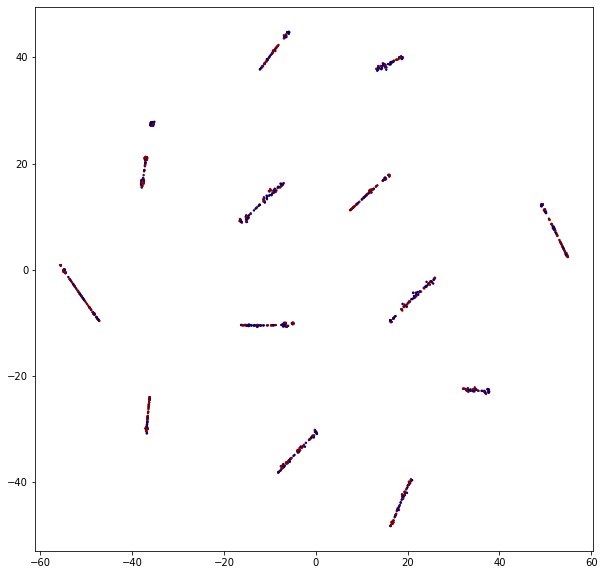

epoch: 1, test: loss_g: 3.4542 loss_g_ae: 3.4470 loss_g_clas: 0.1895 loss_d: 0.0710 loss_z_clas: 0.6599 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9746 accu_g: 0.9554 accu_g_gdy: 0.9955 accu_z_clas: 0.6005 bleu: 0.1861 equal: 0.0006 spam: 0.0532 bleu_remain: 0.1776 acc_remain: 0.9957


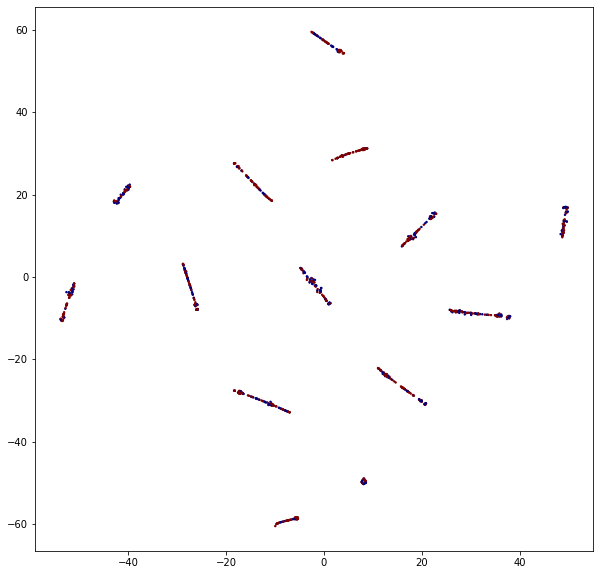

epoch: 1, manual: loss_g: 3.7699 loss_g_ae: 3.7667 loss_g_clas: 0.1741 loss_d: 0.0694 loss_z_clas: 0.6873 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9780 accu_g: 0.9680 accu_g_gdy: 0.9970 accu_z_clas: 0.5230 bleu: 0.1875 equal: 0.0000 spam: 0.0620 bleu_remain: 0.1971 acc_remain: 0.9968


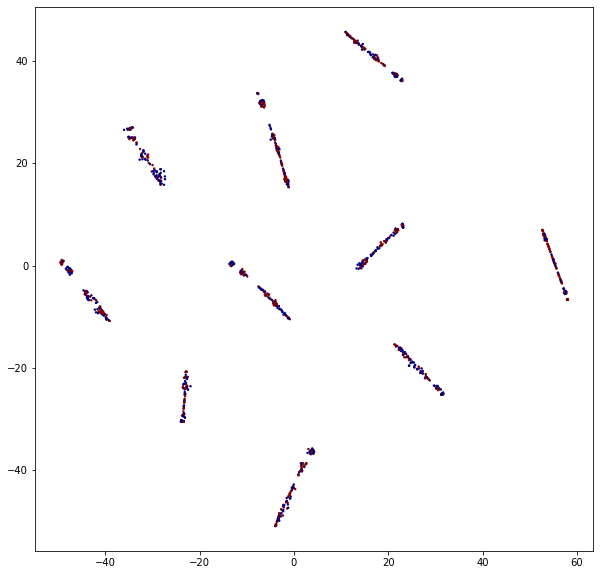

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 2, step: 1, loss_d: 0.0224 accu_d: 1.0000
epoch: 2, step: 1, loss_z: 0.6432 accu_z: 0.5781
epoch: 2, step: 1, loss_g: 3.3027 loss_g_ae: 3.2835 loss_g_clas: 0.2504 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9688 accu_g_gdy: 1.0000 accu_z_clas: 0.5625
epoch: 2, step: 500, loss_d: 0.0393 accu_d: 0.9891
epoch: 2, step: 500, loss_z: 0.6501 accu_z: 0.6016
epoch: 2, step: 500, loss_g: 3.4676 loss_g_ae: 3.4490 loss_g_clas: 0.1685 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9578 accu_g_gdy: 0.9656 accu_z_clas: 0.6000
epoch: 2, step: 1000, loss_d: 0.0622 accu_d: 0.9781
epoch: 2, step: 1000, loss_z: 0.6589 accu_z: 0.6016
epoch: 2, step: 1000, loss_g: 3.3573 loss_g_ae: 3.3315 loss_g_clas: 0.2284 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9313 accu_g_gdy: 0.9375 accu_z_clas: 0.5938
epoch: 2, step: 1500, loss_d: 0.0702 accu_d: 0.9734
epoch: 2, step: 

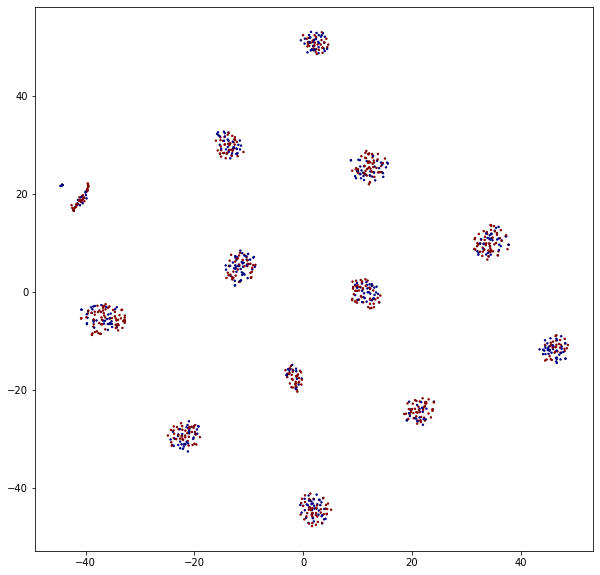

epoch: 2, test: loss_g: 0.2595 loss_g_ae: 0.2588 loss_g_clas: 5.7022 loss_d: 0.0685 loss_z_clas: 0.6586 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9761 accu_g: 0.1365 accu_g_gdy: 0.1196 accu_z_clas: 0.5999 bleu: 83.7333 equal: 0.5834 spam: 0.0013 bleu_remain: 65.8986 acc_remain: 0.2616


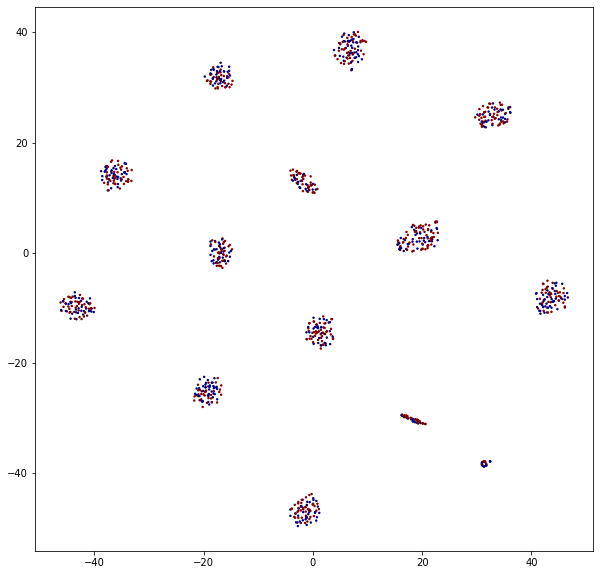

epoch: 2, manual: loss_g: 0.2643 loss_g_ae: 0.2640 loss_g_clas: 5.7701 loss_d: 0.0681 loss_z_clas: 0.6919 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9780 accu_g: 0.1180 accu_g_gdy: 0.1020 accu_z_clas: 0.5000 bleu: 84.5970 equal: 0.5530 spam: 0.0040 bleu_remain: 66.8221 acc_remain: 0.2050


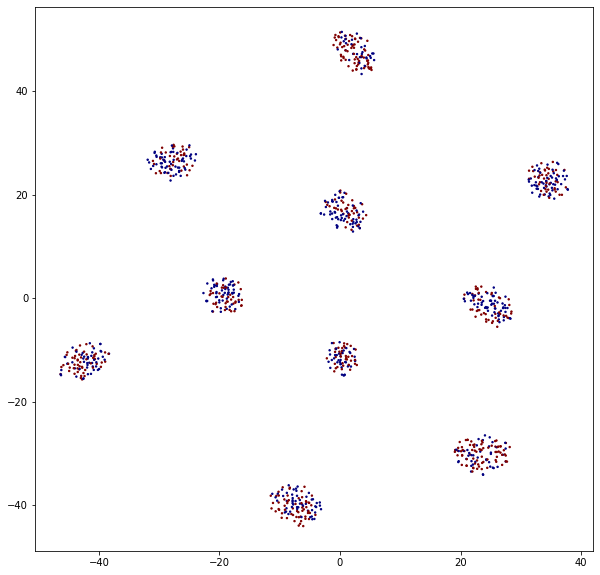

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 3, step: 1, loss_d: 0.0099 accu_d: 1.0000
epoch: 3, step: 1, loss_z: 0.6749 accu_z: 0.5938
epoch: 3, step: 1, loss_g: 0.3615 loss_g_ae: 0.3509 loss_g_clas: 3.9000 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.2812 accu_g_gdy: 0.2344 accu_z_clas: 0.5469
epoch: 3, step: 500, loss_d: 0.0310 accu_d: 0.9906
epoch: 3, step: 500, loss_z: 0.6689 accu_z: 0.6016
epoch: 3, step: 500, loss_g: 0.3541 loss_g_ae: 0.3372 loss_g_clas: 5.3561 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.1703 accu_g_gdy: 0.1609 accu_z_clas: 0.6078
epoch: 3, step: 1000, loss_d: 0.0567 accu_d: 0.9812
epoch: 3, step: 1000, loss_z: 0.6601 accu_z: 0.6109
epoch: 3, step: 1000, loss_g: 0.5483 loss_g_ae: 0.5184 loss_g_clas: 4.9887 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.2281 accu_g_gdy: 0.2078 accu_z_clas: 0.5906
epoch: 3, step: 1500, loss_d: 0.0345 accu_d: 0.9875
epoch: 3, step: 

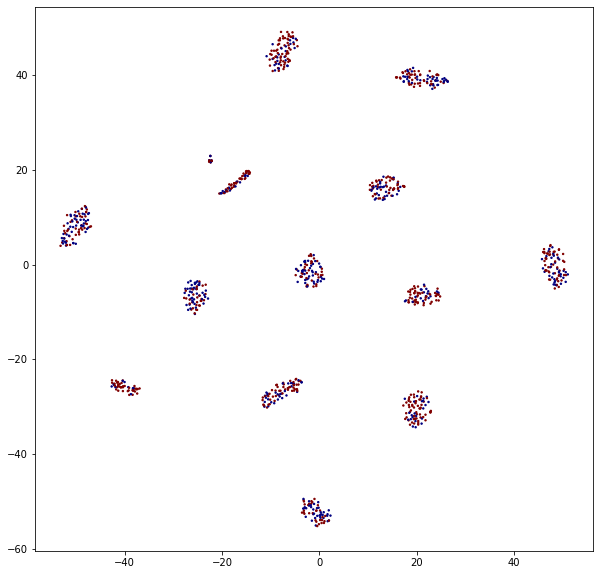

epoch: 3, test: loss_g: 0.0919 loss_g_ae: 0.0917 loss_g_clas: 7.4839 loss_d: 0.0678 loss_z_clas: 0.6584 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9763 accu_g: 0.0517 accu_g_gdy: 0.0545 accu_z_clas: 0.6033 bleu: 92.5242 equal: 0.7861 spam: 0.0003 bleu_remain: 70.8768 acc_remain: 0.1797


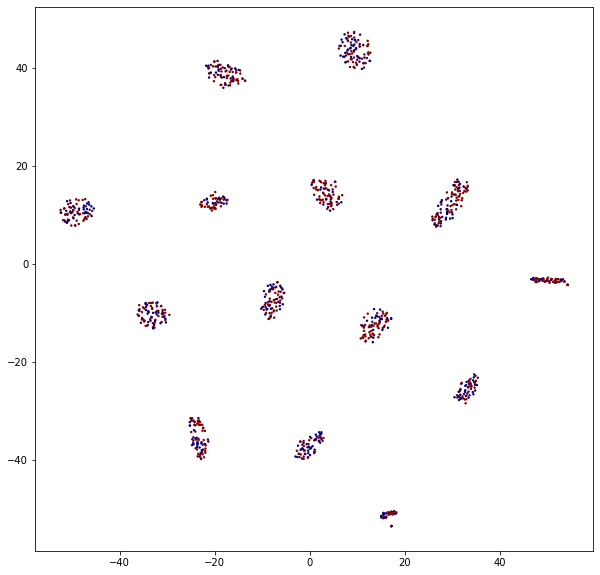

epoch: 3, manual: loss_g: 0.0918 loss_g_ae: 0.0916 loss_g_clas: 7.3096 loss_d: 0.0677 loss_z_clas: 0.6931 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9770 accu_g: 0.0520 accu_g_gdy: 0.0610 accu_z_clas: 0.5210 bleu: 93.3496 equal: 0.7840 spam: 0.0020 bleu_remain: 70.8202 acc_remain: 0.1891


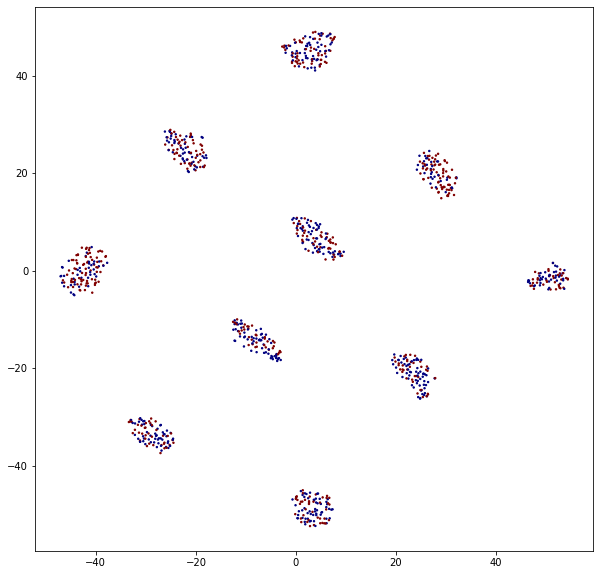

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 4, step: 1, loss_d: 0.0254 accu_d: 0.9844
epoch: 4, step: 1, loss_z: 0.6328 accu_z: 0.5938
epoch: 4, step: 1, loss_g: 0.1773 loss_g_ae: 0.1736 loss_g_clas: 6.6171 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0938 accu_g_gdy: 0.0469 accu_z_clas: 0.5000
epoch: 4, step: 500, loss_d: 0.0275 accu_d: 0.9922
epoch: 4, step: 500, loss_z: 0.6530 accu_z: 0.6219
epoch: 4, step: 500, loss_g: 0.1760 loss_g_ae: 0.1677 loss_g_clas: 7.4400 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0813 accu_g_gdy: 0.0813 accu_z_clas: 0.6156
epoch: 4, step: 1000, loss_d: 0.0321 accu_d: 0.9875
epoch: 4, step: 1000, loss_z: 0.6671 accu_z: 0.5906
epoch: 4, step: 1000, loss_g: 0.1756 loss_g_ae: 0.1722 loss_g_clas: 7.5497 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.1062 accu_g_gdy: 0.1000 accu_z_clas: 0.5781
epoch: 4, step: 1500, loss_d: 0.0334 accu_d: 0.9906
epoch: 4, step: 

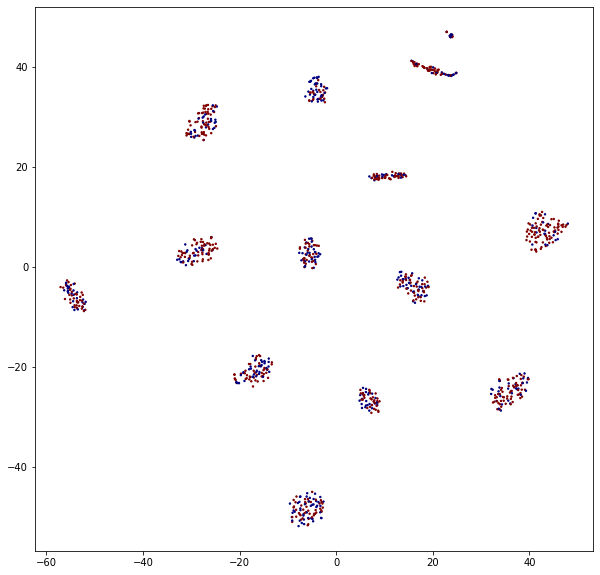

epoch: 4, test: loss_g: 0.0611 loss_g_ae: 0.0610 loss_g_clas: 8.7196 loss_d: 0.0723 loss_z_clas: 0.6580 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9758 accu_g: 0.0419 accu_g_gdy: 0.0462 accu_z_clas: 0.6040 bleu: 94.8186 equal: 0.8461 spam: 0.0002 bleu_remain: 72.3857 acc_remain: 0.1824


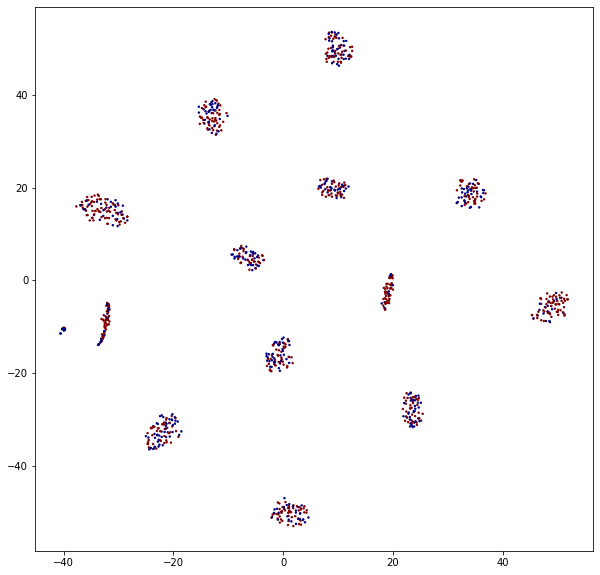

epoch: 4, manual: loss_g: 0.0592 loss_g_ae: 0.0591 loss_g_clas: 8.6444 loss_d: 0.0752 loss_z_clas: 0.6934 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9770 accu_g: 0.0410 accu_g_gdy: 0.0410 accu_z_clas: 0.5210 bleu: 95.3532 equal: 0.8390 spam: 0.0000 bleu_remain: 72.8030 acc_remain: 0.1373


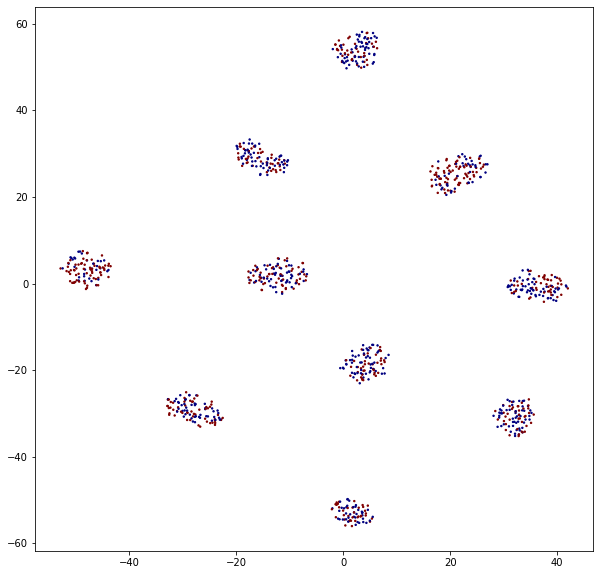

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 5, step: 1, loss_d: 0.0060 accu_d: 1.0000
epoch: 5, step: 1, loss_z: 0.6553 accu_z: 0.6094
epoch: 5, step: 1, loss_g: 0.0965 loss_g_ae: 0.0926 loss_g_clas: 9.3933 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0156 accu_g_gdy: 0.0312 accu_z_clas: 0.6562
epoch: 5, step: 500, loss_d: 0.0640 accu_d: 0.9781
epoch: 5, step: 500, loss_z: 0.6414 accu_z: 0.6312
epoch: 5, step: 500, loss_g: 0.1076 loss_g_ae: 0.1057 loss_g_clas: 8.3883 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0625 accu_g_gdy: 0.0766 accu_z_clas: 0.5859
epoch: 5, step: 1000, loss_d: 0.0406 accu_d: 0.9875
epoch: 5, step: 1000, loss_z: 0.6712 accu_z: 0.5969
epoch: 5, step: 1000, loss_g: 0.1315 loss_g_ae: 0.1293 loss_g_clas: 9.1751 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0641 accu_g_gdy: 0.0656 accu_z_clas: 0.6141
epoch: 5, step: 1500, loss_d: 0.0339 accu_d: 0.9922
epoch: 5, step: 

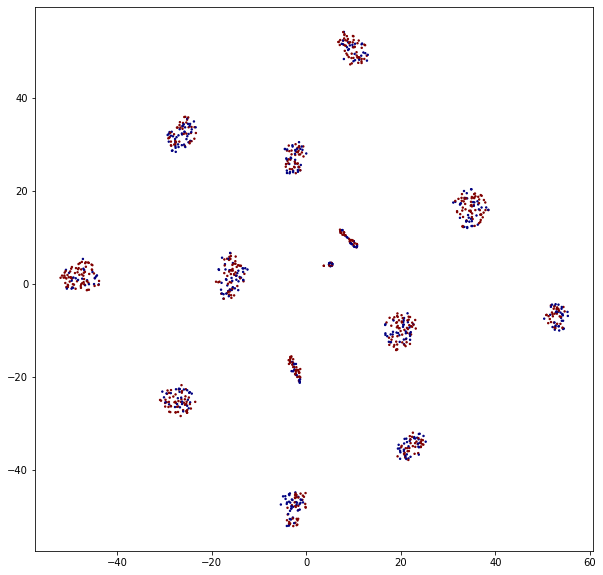

epoch: 5, test: loss_g: 0.0399 loss_g_ae: 0.0398 loss_g_clas: 10.0104 loss_d: 0.0758 loss_z_clas: 0.6588 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9760 accu_g: 0.0356 accu_g_gdy: 0.0381 accu_z_clas: 0.6022 bleu: 96.3267 equal: 0.8887 spam: 0.0004 bleu_remain: 72.3626 acc_remain: 0.1638


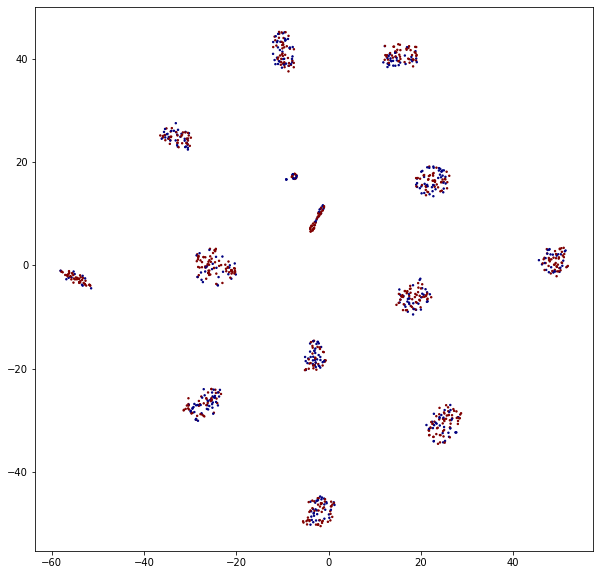

epoch: 5, manual: loss_g: 0.0375 loss_g_ae: 0.0374 loss_g_clas: 9.9404 loss_d: 0.0678 loss_z_clas: 0.6852 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9820 accu_g: 0.0320 accu_g_gdy: 0.0360 accu_z_clas: 0.5370 bleu: 97.1202 equal: 0.9010 spam: 0.0000 bleu_remain: 71.4708 acc_remain: 0.2554


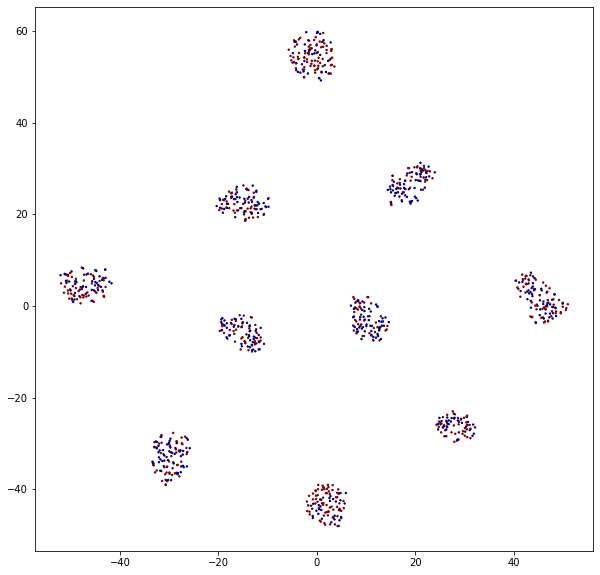

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 6, step: 1, loss_d: 0.0139 accu_d: 1.0000
epoch: 6, step: 1, loss_z: 0.6959 accu_z: 0.5312
epoch: 6, step: 1, loss_g: 0.0726 loss_g_ae: 0.0704 loss_g_clas: 8.6634 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0312 accu_g_gdy: 0.0781 accu_z_clas: 0.5469
epoch: 6, step: 500, loss_d: 0.0385 accu_d: 0.9859
epoch: 6, step: 500, loss_z: 0.6552 accu_z: 0.6078
epoch: 6, step: 500, loss_g: 0.0768 loss_g_ae: 0.0756 loss_g_clas: 9.3845 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0422 accu_g_gdy: 0.0406 accu_z_clas: 0.6297
epoch: 6, step: 1000, loss_d: 0.0215 accu_d: 0.9938
epoch: 6, step: 1000, loss_z: 0.6580 accu_z: 0.6062
epoch: 6, step: 1000, loss_g: 0.0729 loss_g_ae: 0.0714 loss_g_clas: 10.1744 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0406 accu_g_gdy: 0.0406 accu_z_clas: 0.6125
epoch: 6, step: 1500, loss_d: 0.0248 accu_d: 0.9922
epoch: 6, step:

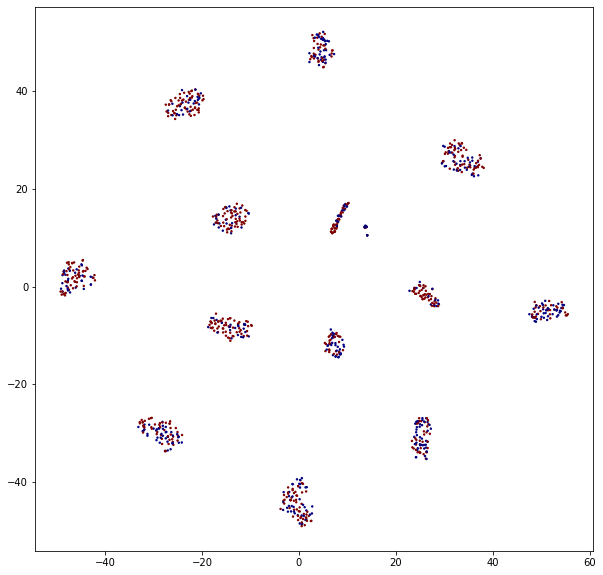

epoch: 6, test: loss_g: 0.0240 loss_g_ae: 0.0240 loss_g_clas: 10.4532 loss_d: 0.0793 loss_z_clas: 0.6588 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9756 accu_g: 0.0327 accu_g_gdy: 0.0343 accu_z_clas: 0.6037 bleu: 97.6379 equal: 0.9261 spam: 0.0001 bleu_remain: 71.8044 acc_remain: 0.1705


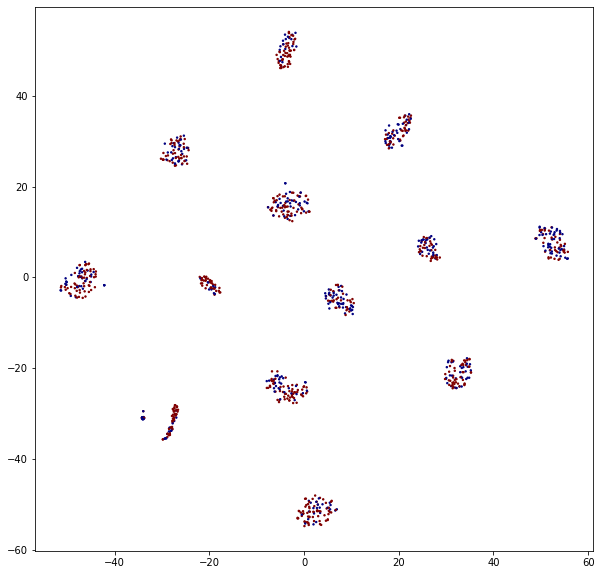

epoch: 6, manual: loss_g: 0.0239 loss_g_ae: 0.0222 loss_g_clas: 10.3985 loss_d: 0.0717 loss_z_clas: 0.6859 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9810 accu_g: 0.0300 accu_g_gdy: 0.0300 accu_z_clas: 0.5370 bleu: 98.0496 equal: 0.9290 spam: 0.0000 bleu_remain: 68.9384 acc_remain: 0.1552


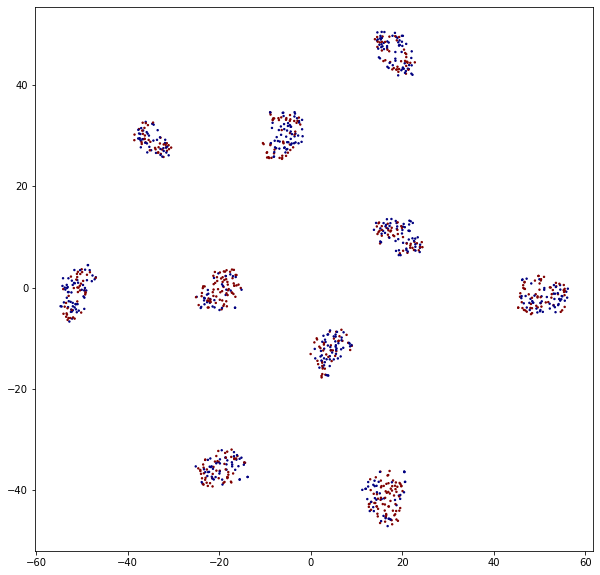

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 7, step: 1, loss_d: 0.0068 accu_d: 1.0000
epoch: 7, step: 1, loss_z: 0.6486 accu_z: 0.6719
epoch: 7, step: 1, loss_g: 0.0506 loss_g_ae: 0.0495 loss_g_clas: 9.5086 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0469 accu_g_gdy: 0.0000 accu_z_clas: 0.5938
epoch: 7, step: 500, loss_d: 0.0230 accu_d: 0.9938
epoch: 7, step: 500, loss_z: 0.6473 accu_z: 0.6094
epoch: 7, step: 500, loss_g: 0.0598 loss_g_ae: 0.0586 loss_g_clas: 11.2583 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0406 accu_g_gdy: 0.0359 accu_z_clas: 0.5984
epoch: 7, step: 1000, loss_d: 0.0317 accu_d: 0.9906
epoch: 7, step: 1000, loss_z: 0.6575 accu_z: 0.6078
epoch: 7, step: 1000, loss_g: 0.0489 loss_g_ae: 0.0481 loss_g_clas: 11.1746 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0312 accu_g_gdy: 0.0359 accu_z_clas: 0.6094
epoch: 7, step: 1500, loss_d: 0.0173 accu_d: 0.9969
epoch: 7, step

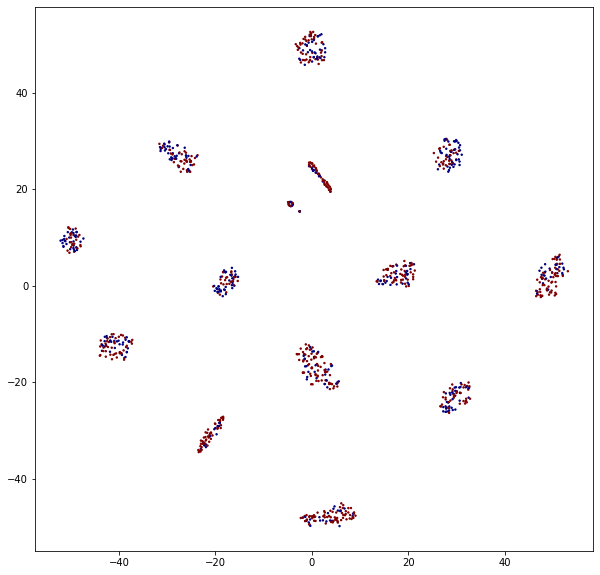

epoch: 7, test: loss_g: 0.0190 loss_g_ae: 0.0189 loss_g_clas: 11.0863 loss_d: 0.0841 loss_z_clas: 0.6581 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9746 accu_g: 0.0310 accu_g_gdy: 0.0322 accu_z_clas: 0.6052 bleu: 98.1199 equal: 0.9401 spam: 0.0001 bleu_remain: 70.7117 acc_remain: 0.1535


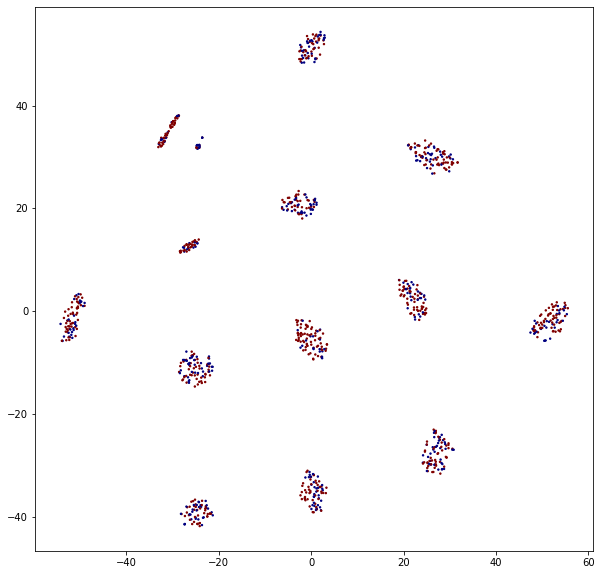

epoch: 7, manual: loss_g: 0.0206 loss_g_ae: 0.0192 loss_g_clas: 10.9721 loss_d: 0.0792 loss_z_clas: 0.6897 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9770 accu_g: 0.0300 accu_g_gdy: 0.0350 accu_z_clas: 0.5230 bleu: 98.4652 equal: 0.9440 spam: 0.0000 bleu_remain: 74.0455 acc_remain: 0.2017


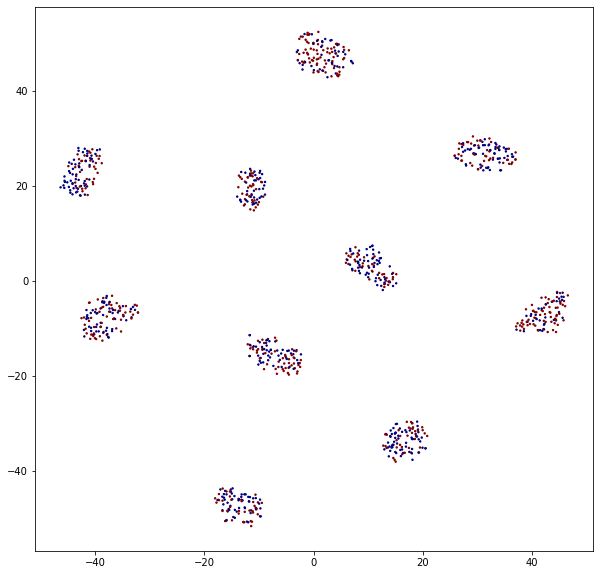

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 8, step: 1, loss_d: 0.0233 accu_d: 0.9844
epoch: 8, step: 1, loss_z: 0.7032 accu_z: 0.5312
epoch: 8, step: 1, loss_g: 0.0271 loss_g_ae: 0.0263 loss_g_clas: 10.6098 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0312 accu_g_gdy: 0.0156 accu_z_clas: 0.6406
epoch: 8, step: 500, loss_d: 0.0102 accu_d: 0.9953
epoch: 8, step: 500, loss_z: 0.6751 accu_z: 0.6156
epoch: 8, step: 500, loss_g: 0.0483 loss_g_ae: 0.0476 loss_g_clas: 11.6313 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0375 accu_g_gdy: 0.0437 accu_z_clas: 0.6141
epoch: 8, step: 1000, loss_d: 0.0116 accu_d: 0.9938
epoch: 8, step: 1000, loss_z: 0.6421 accu_z: 0.6469
epoch: 8, step: 1000, loss_g: 0.0480 loss_g_ae: 0.0469 loss_g_clas: 12.5597 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0359 accu_g_gdy: 0.0406 accu_z_clas: 0.5766
epoch: 8, step: 1500, loss_d: 0.0160 accu_d: 0.9938
epoch: 8, ste

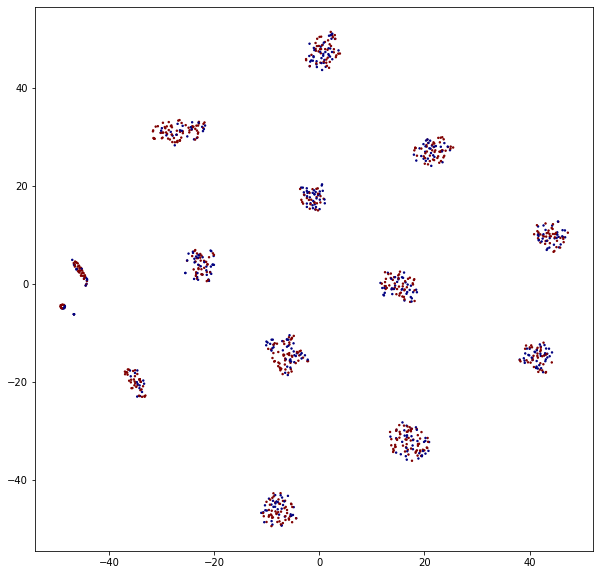

epoch: 8, test: loss_g: 0.0166 loss_g_ae: 0.0166 loss_g_clas: 12.3667 loss_d: 0.0930 loss_z_clas: 0.6581 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9737 accu_g: 0.0311 accu_g_gdy: 0.0324 accu_z_clas: 0.6051 bleu: 98.3373 equal: 0.9470 spam: 0.0000 bleu_remain: 70.5202 acc_remain: 0.1585


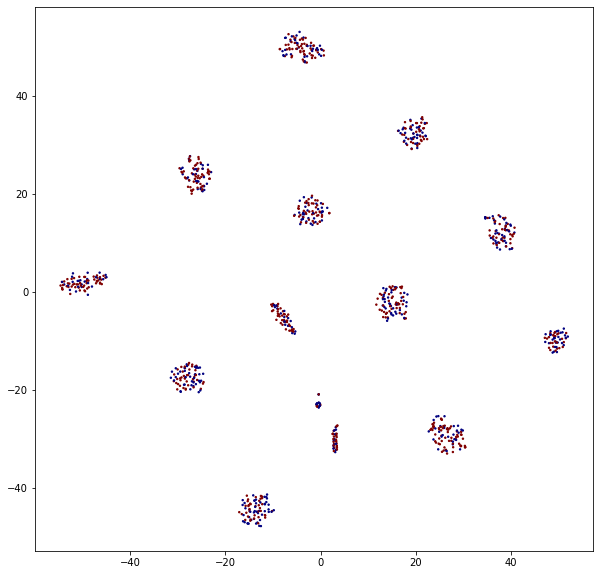

epoch: 8, manual: loss_g: 0.0221 loss_g_ae: 0.0212 loss_g_clas: 12.2626 loss_d: 0.0871 loss_z_clas: 0.6921 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9810 accu_g: 0.0330 accu_g_gdy: 0.0360 accu_z_clas: 0.5230 bleu: 98.2781 equal: 0.9360 spam: 0.0000 bleu_remain: 72.7772 acc_remain: 0.2269


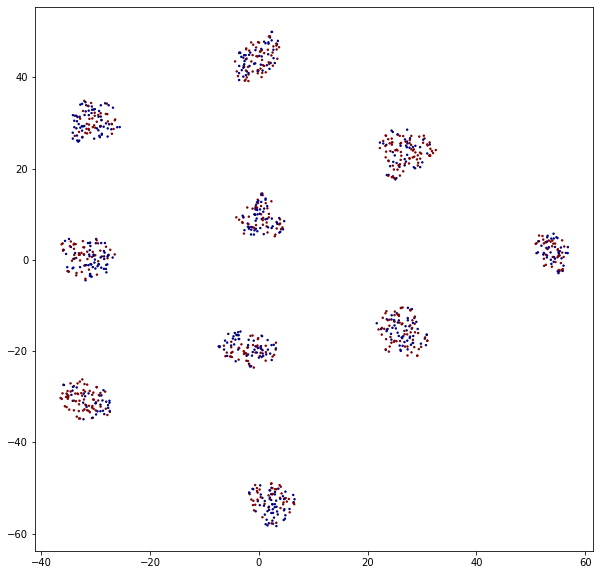

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 9, step: 1, loss_d: 0.0133 accu_d: 0.9844
epoch: 9, step: 1, loss_z: 0.6997 accu_z: 0.5469
epoch: 9, step: 1, loss_g: 0.0353 loss_g_ae: 0.0338 loss_g_clas: 12.3191 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0000 accu_g_gdy: 0.0000 accu_z_clas: 0.5469
epoch: 9, step: 500, loss_d: 0.0125 accu_d: 0.9953
epoch: 9, step: 500, loss_z: 0.6585 accu_z: 0.5938
epoch: 9, step: 500, loss_g: 0.0376 loss_g_ae: 0.0370 loss_g_clas: 12.5533 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0203 accu_g_gdy: 0.0312 accu_z_clas: 0.5953
epoch: 9, step: 1000, loss_d: 0.0161 accu_d: 0.9984
epoch: 9, step: 1000, loss_z: 0.6605 accu_z: 0.5984
epoch: 9, step: 1000, loss_g: 0.0495 loss_g_ae: 0.0488 loss_g_clas: 12.9666 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0422 accu_g_gdy: 0.0328 accu_z_clas: 0.5516
epoch: 9, step: 1500, loss_d: 0.0177 accu_d: 0.9906
epoch: 9, ste

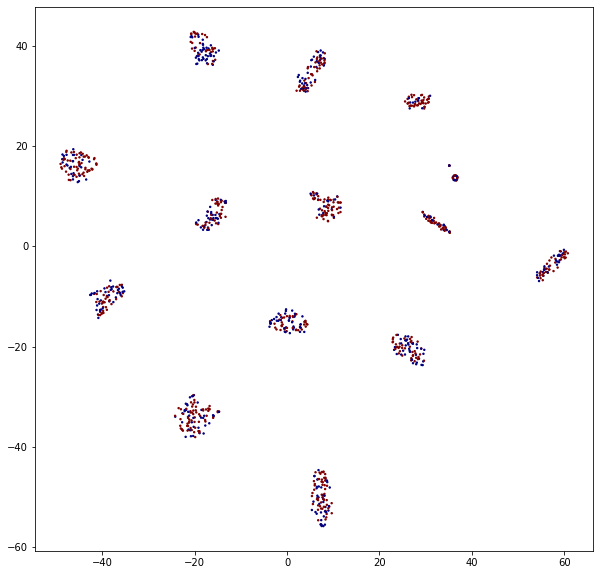

epoch: 9, test: loss_g: 0.0145 loss_g_ae: 0.0143 loss_g_clas: 13.7788 loss_d: 0.0995 loss_z_clas: 0.6586 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9737 accu_g: 0.0291 accu_g_gdy: 0.0297 accu_z_clas: 0.6037 bleu: 98.6905 equal: 0.9579 spam: 0.0000 bleu_remain: 68.2482 acc_remain: 0.1231


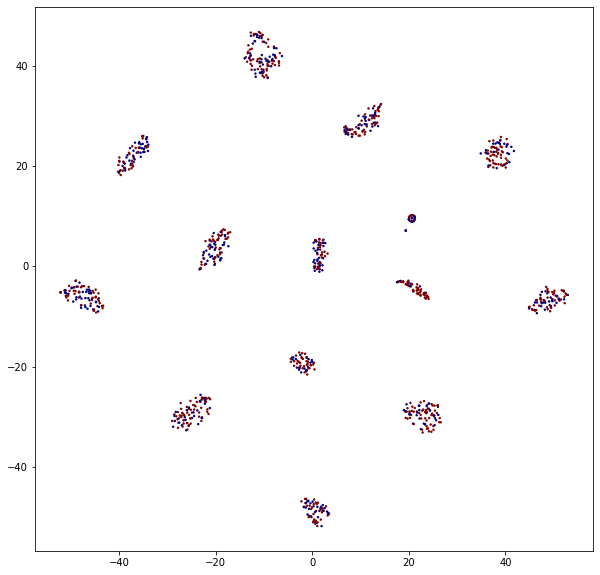

epoch: 9, manual: loss_g: 0.0175 loss_g_ae: 0.0134 loss_g_clas: 13.7757 loss_d: 0.0886 loss_z_clas: 0.6859 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9760 accu_g: 0.0350 accu_g_gdy: 0.0340 accu_z_clas: 0.5370 bleu: 98.8718 equal: 0.9570 spam: 0.0000 bleu_remain: 68.7024 acc_remain: 0.2160


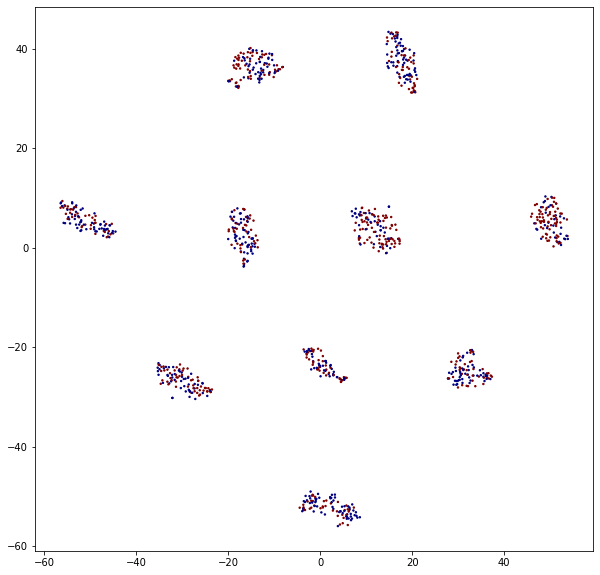

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 10, step: 1, loss_d: 0.0140 accu_d: 1.0000
epoch: 10, step: 1, loss_z: 0.6734 accu_z: 0.5469
epoch: 10, step: 1, loss_g: 0.0461 loss_g_ae: 0.0448 loss_g_clas: 13.2588 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0156 accu_g_gdy: 0.0156 accu_z_clas: 0.6406
epoch: 10, step: 500, loss_d: 0.0178 accu_d: 0.9953
epoch: 10, step: 500, loss_z: 0.6640 accu_z: 0.5797
epoch: 10, step: 500, loss_g: 0.0388 loss_g_ae: 0.0377 loss_g_clas: 13.9467 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0203 accu_g_gdy: 0.0297 accu_z_clas: 0.5844
epoch: 10, step: 1000, loss_d: 0.0056 accu_d: 1.0000
epoch: 10, step: 1000, loss_z: 0.6658 accu_z: 0.5813
epoch: 10, step: 1000, loss_g: 0.0346 loss_g_ae: 0.0336 loss_g_clas: 13.3824 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0312 accu_g_gdy: 0.0391 accu_z_clas: 0.6000
epoch: 10, step: 1500, loss_d: 0.0214 accu_d: 0.9938
epo

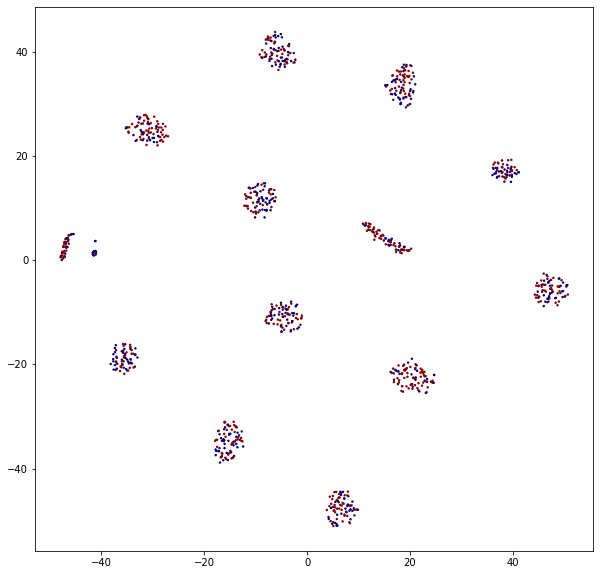

epoch: 10, test: loss_g: 0.0106 loss_g_ae: 0.0104 loss_g_clas: 13.6507 loss_d: 0.1042 loss_z_clas: 0.6590 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9729 accu_g: 0.0302 accu_g_gdy: 0.0310 accu_z_clas: 0.6035 bleu: 98.9576 equal: 0.9663 spam: 0.0000 bleu_remain: 62.6876 acc_remain: 0.1464


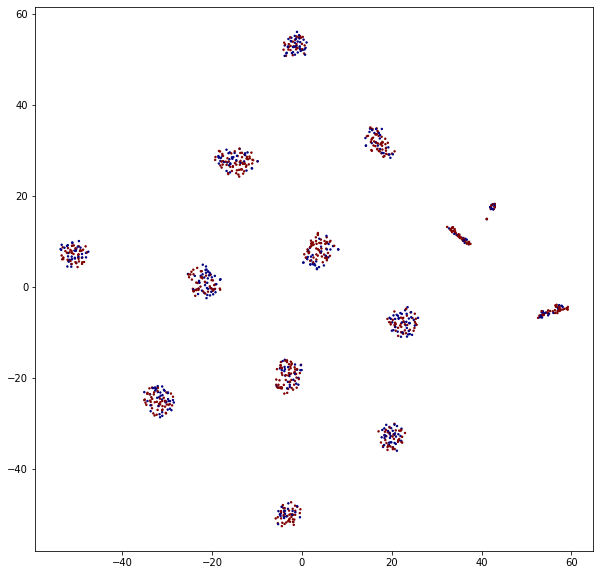

epoch: 10, manual: loss_g: 0.0159 loss_g_ae: 0.0120 loss_g_clas: 13.8063 loss_d: 0.0920 loss_z_clas: 0.6860 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9760 accu_g: 0.0290 accu_g_gdy: 0.0330 accu_z_clas: 0.5370 bleu: 98.8544 equal: 0.9570 spam: 0.0000 bleu_remain: 69.8682 acc_remain: 0.1909


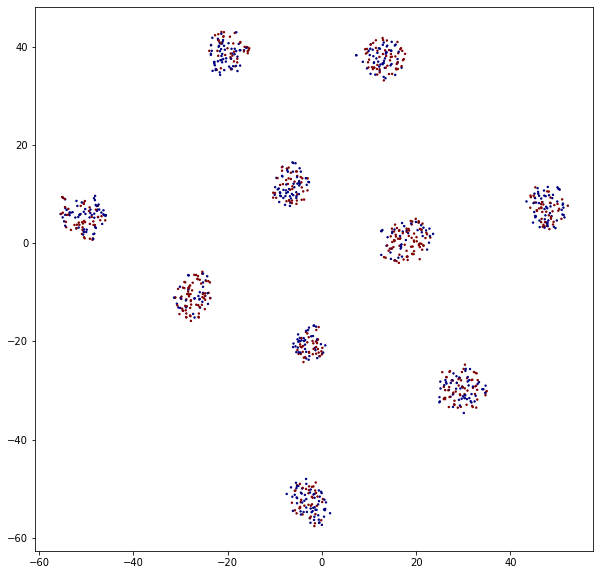

gamma: 0.5, lambda_g: 0.1, lambda_z: 0.5, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 11, step: 1, loss_d: 0.0023 accu_d: 1.0000
epoch: 11, step: 1, loss_z: 0.6527 accu_z: 0.7344
epoch: 11, step: 1, loss_g: 1.0811 loss_g_ae: 0.0323 loss_g_clas: 13.8002 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0312 accu_g_gdy: 0.0312 accu_z_clas: 0.6250
epoch: 11, step: 500, loss_d: 0.0112 accu_d: 0.9953
epoch: 11, step: 500, loss_z: 0.6740 accu_z: 0.5813
epoch: 11, step: 500, loss_g: 0.1057 loss_g_ae: 0.2839 loss_g_clas: 1.4103 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.7891 accu_g_gdy: 0.8109 accu_z_clas: 0.6016
epoch: 11, step: 1000, loss_d: 0.0098 accu_d: 0.9969
epoch: 11, step: 1000, loss_z: 0.6592 accu_z: 0.6000
epoch: 11, step: 1000, loss_g: 0.0137 loss_g_ae: 0.2068 loss_g_clas: 1.3142 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.7937 accu_g_gdy: 0.8219 accu_z_clas: 0.6094
epoch: 11, step: 1500, loss_d: 0.0249 accu_d: 0.9891
epoch

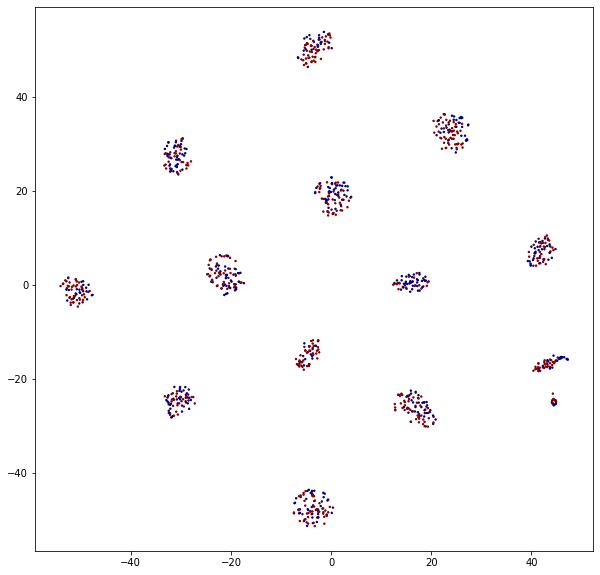

epoch: 11, test: loss_g: -0.1935 loss_g_ae: 0.0701 loss_g_clas: 0.6602 loss_d: 0.1152 loss_z_clas: 0.6603 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9716 accu_g: 0.8851 accu_g_gdy: 0.8844 accu_z_clas: 0.6028 bleu: 63.6519 equal: 0.0910 spam: 0.0001 bleu_remain: 59.4530 acc_remain: 0.9555


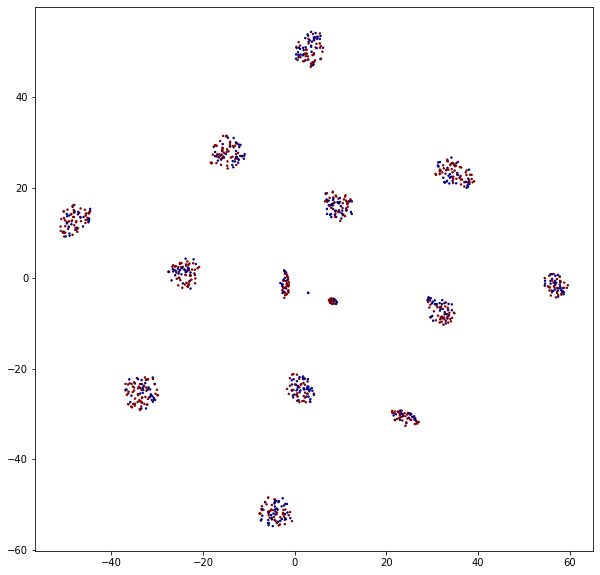

epoch: 11, manual: loss_g: -0.1689 loss_g_ae: 0.0696 loss_g_clas: 0.8941 loss_d: 0.1086 loss_z_clas: 0.6901 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9790 accu_g: 0.8540 accu_g_gdy: 0.8590 accu_z_clas: 0.5230 bleu: 65.8024 equal: 0.1000 spam: 0.0000 bleu_remain: 61.4828 acc_remain: 0.9447


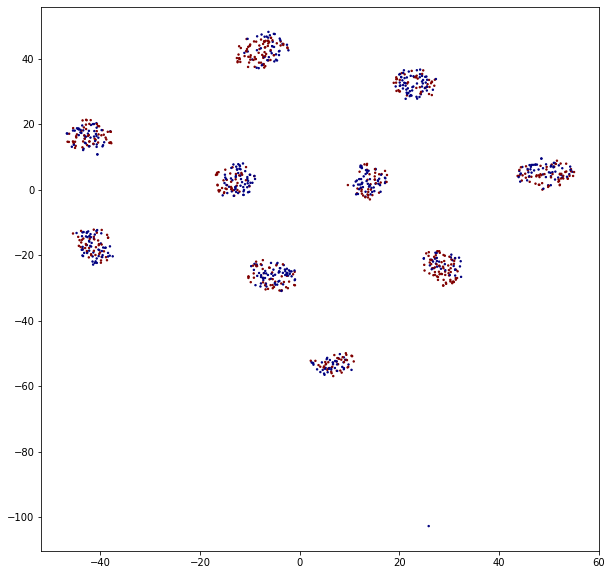

gamma: 0.25, lambda_g: 0.1, lambda_z: 0.5, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 12, step: 1, loss_d: 0.0012 accu_d: 1.0000
epoch: 12, step: 1, loss_z: 0.6671 accu_z: 0.5625
epoch: 12, step: 1, loss_g: -0.2468 loss_g_ae: 0.0493 loss_g_clas: 0.1036 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9688 accu_g_gdy: 0.9688 accu_z_clas: 0.6719
epoch: 12, step: 500, loss_d: 0.0037 accu_d: 1.0000
epoch: 12, step: 500, loss_z: 0.6656 accu_z: 0.5984
epoch: 12, step: 500, loss_g: -0.0548 loss_g_ae: 0.1907 loss_g_clas: 0.7727 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8859 accu_g_gdy: 0.8531 accu_z_clas: 0.6016
epoch: 12, step: 1000, loss_d: 0.0099 accu_d: 0.9969
epoch: 12, step: 1000, loss_z: 0.6786 accu_z: 0.5828
epoch: 12, step: 1000, loss_g: -0.1143 loss_g_ae: 0.1465 loss_g_clas: 0.5956 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8969 accu_g_gdy: 0.9000 accu_z_clas: 0.6500
epoch: 12, step: 1500, loss_d: 0.0182 accu_d: 0.9938
ep

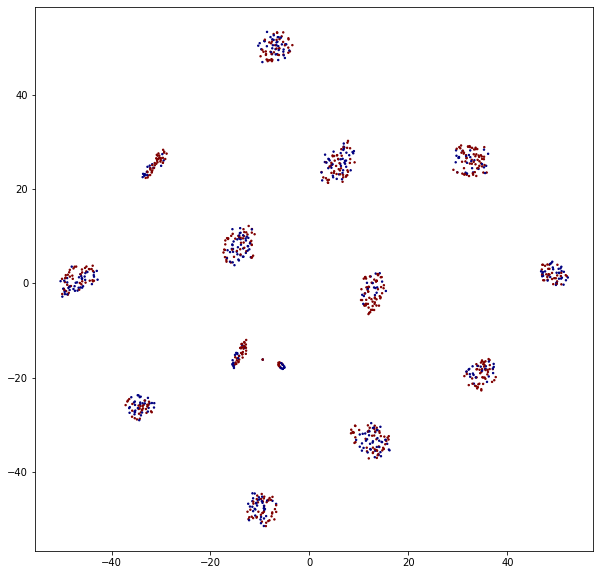

epoch: 12, test: loss_g: -0.1897 loss_g_ae: 0.0629 loss_g_clas: 0.7735 loss_d: 0.1159 loss_z_clas: 0.6610 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9727 accu_g: 0.8811 accu_g_gdy: 0.8810 accu_z_clas: 0.6022 bleu: 65.1044 equal: 0.0928 spam: 0.0000 bleu_remain: 60.8078 acc_remain: 0.9541


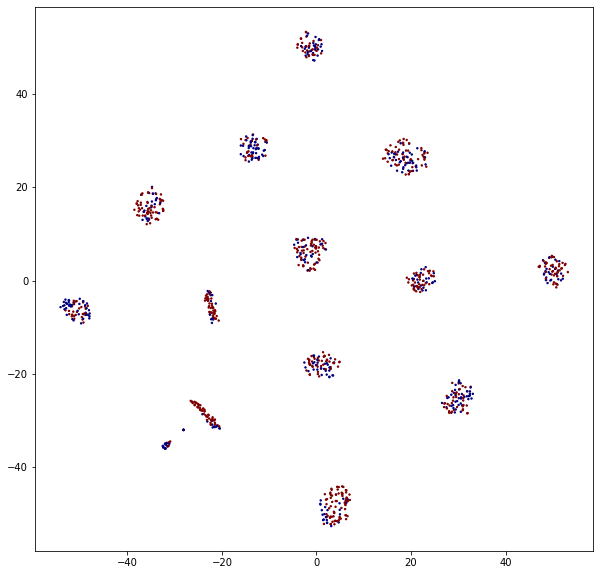

epoch: 12, manual: loss_g: -0.1783 loss_g_ae: 0.0577 loss_g_clas: 1.0070 loss_d: 0.1140 loss_z_clas: 0.6869 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9700 accu_g: 0.8530 accu_g_gdy: 0.8580 accu_z_clas: 0.5370 bleu: 68.0906 equal: 0.1110 spam: 0.0000 bleu_remain: 63.3978 acc_remain: 0.9457


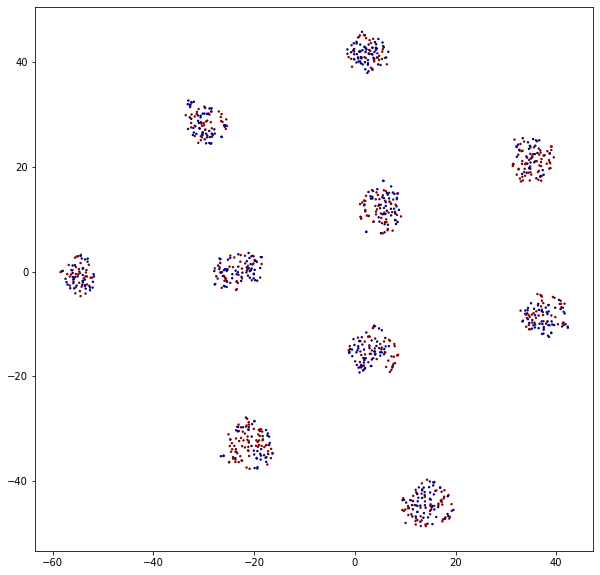

gamma: 0.125, lambda_g: 0.1, lambda_z: 0.5, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 13, step: 1, loss_d: 0.0034 accu_d: 1.0000
epoch: 13, step: 1, loss_z: 0.6283 accu_z: 0.6719
epoch: 13, step: 1, loss_g: -0.0836 loss_g_ae: 0.1376 loss_g_clas: 1.1720 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8125 accu_g_gdy: 0.8438 accu_z_clas: 0.5000
epoch: 13, step: 500, loss_d: 0.0124 accu_d: 0.9938
epoch: 13, step: 500, loss_z: 0.6671 accu_z: 0.5984
epoch: 13, step: 500, loss_g: -0.1368 loss_g_ae: 0.1241 loss_g_clas: 0.6904 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9062 accu_g_gdy: 0.8922 accu_z_clas: 0.5813
epoch: 13, step: 1000, loss_d: 0.0076 accu_d: 0.9969
epoch: 13, step: 1000, loss_z: 0.6566 accu_z: 0.6125
epoch: 13, step: 1000, loss_g: -0.1015 loss_g_ae: 0.1504 loss_g_clas: 0.7769 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8891 accu_g_gdy: 0.8766 accu_z_clas: 0.5797
epoch: 13, step: 1500, loss_d: 0.0115 accu_d: 0.9938
e

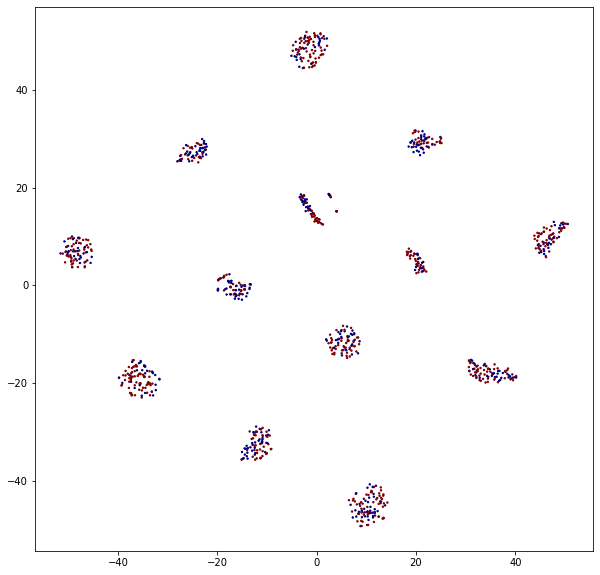

epoch: 13, test: loss_g: -0.1773 loss_g_ae: 0.0616 loss_g_clas: 0.9120 loss_d: 0.1255 loss_z_clas: 0.6610 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9718 accu_g: 0.8741 accu_g_gdy: 0.8741 accu_z_clas: 0.5993 bleu: 66.1314 equal: 0.1069 spam: 0.0001 bleu_remain: 61.2544 acc_remain: 0.9590


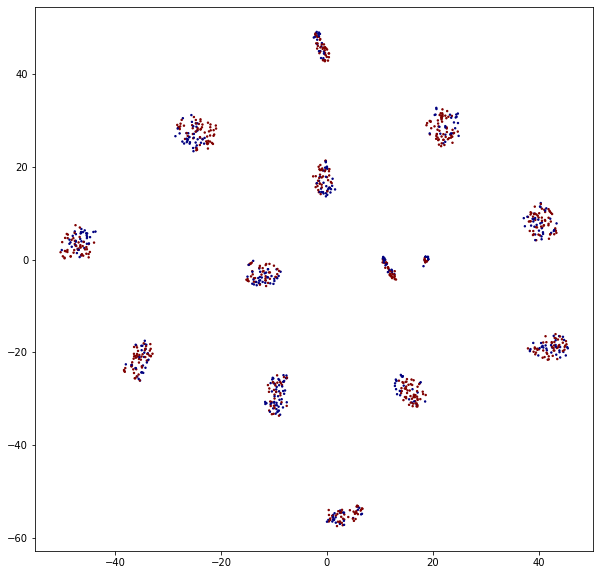

epoch: 13, manual: loss_g: -0.1283 loss_g_ae: 0.0660 loss_g_clas: 1.1737 loss_d: 0.1027 loss_z_clas: 0.6928 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9770 accu_g: 0.8460 accu_g_gdy: 0.8450 accu_z_clas: 0.5000 bleu: 69.1891 equal: 0.1240 spam: 0.0000 bleu_remain: 64.1338 acc_remain: 0.9495


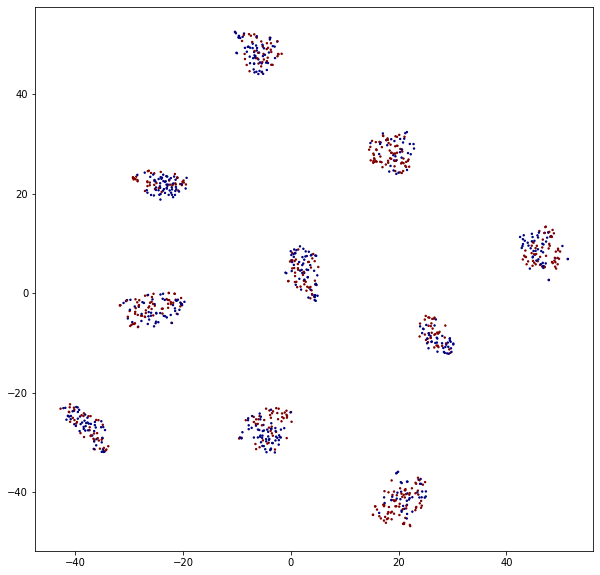

gamma: 0.0625, lambda_g: 0.1, lambda_z: 0.5, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 14, step: 1, loss_d: 0.0047 accu_d: 1.0000
epoch: 14, step: 1, loss_z: 0.6896 accu_z: 0.5938
epoch: 14, step: 1, loss_g: -0.0971 loss_g_ae: 0.0434 loss_g_clas: 1.7122 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8125 accu_g_gdy: 0.7969 accu_z_clas: 0.6406
epoch: 14, step: 500, loss_d: 0.0045 accu_d: 1.0000
epoch: 14, step: 500, loss_z: 0.6487 accu_z: 0.6250
epoch: 14, step: 500, loss_g: -0.1080 loss_g_ae: 0.1349 loss_g_clas: 0.8351 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8891 accu_g_gdy: 0.8906 accu_z_clas: 0.5922
epoch: 14, step: 1000, loss_d: 0.0067 accu_d: 0.9984
epoch: 14, step: 1000, loss_z: 0.6585 accu_z: 0.6000
epoch: 14, step: 1000, loss_g: -0.0890 loss_g_ae: 0.1250 loss_g_clas: 1.0587 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8688 accu_g_gdy: 0.8672 accu_z_clas: 0.6188
epoch: 14, step: 1500, loss_d: 0.0126 accu_d: 0.9953


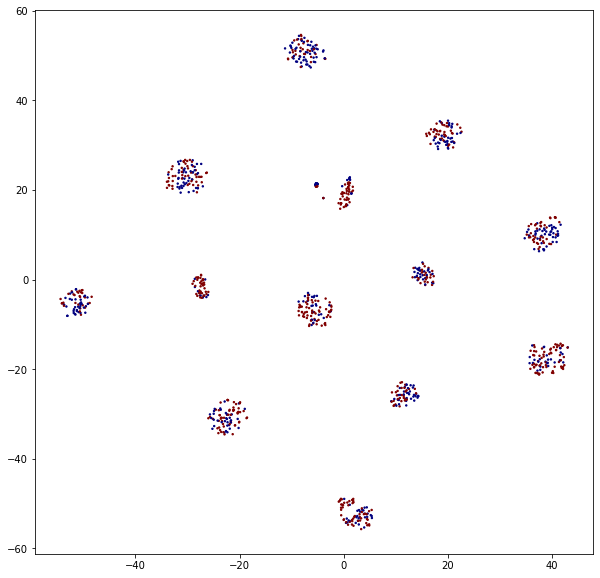

epoch: 14, test: loss_g: -0.1260 loss_g_ae: 0.0966 loss_g_clas: 1.0667 loss_d: 0.1309 loss_z_clas: 0.6603 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9713 accu_g: 0.8639 accu_g_gdy: 0.8632 accu_z_clas: 0.6035 bleu: 65.0664 equal: 0.1061 spam: 0.0001 bleu_remain: 60.2636 acc_remain: 0.9469


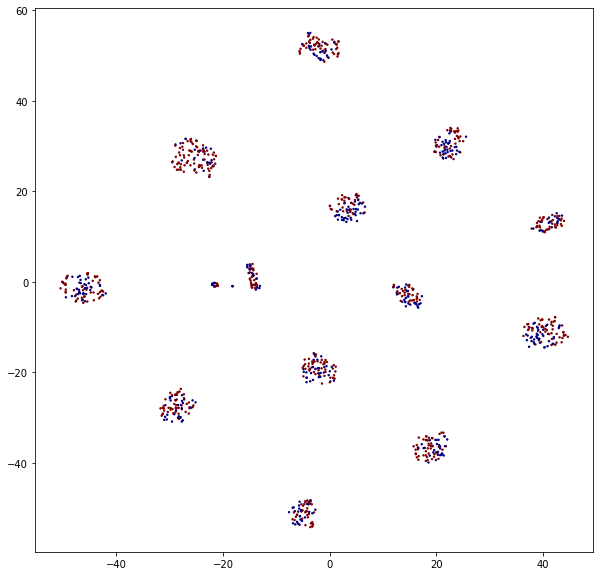

epoch: 14, manual: loss_g: -0.0470 loss_g_ae: 0.1293 loss_g_clas: 1.4464 loss_d: 0.1160 loss_z_clas: 0.6915 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9700 accu_g: 0.8230 accu_g_gdy: 0.8210 accu_z_clas: 0.5230 bleu: 68.5158 equal: 0.1210 spam: 0.0000 bleu_remain: 63.4918 acc_remain: 0.9169


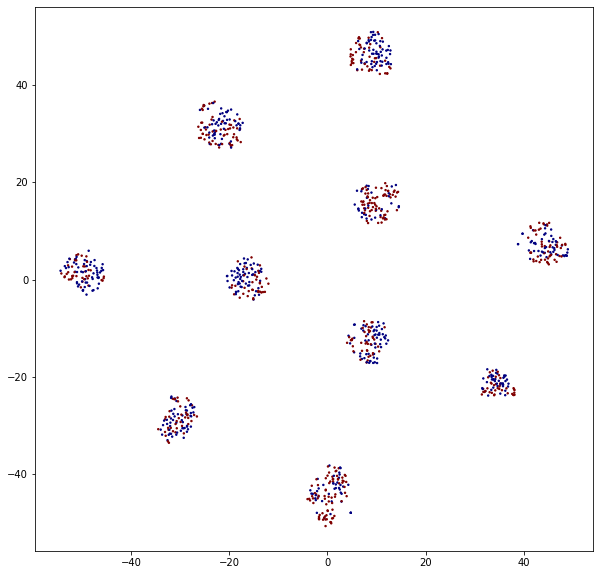

gamma: 0.03125, lambda_g: 0.1, lambda_z: 0.5, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 15, step: 1, loss_d: 0.0094 accu_d: 1.0000
epoch: 15, step: 1, loss_z: 0.6227 accu_z: 0.6719
epoch: 15, step: 1, loss_g: -0.1133 loss_g_ae: 0.1168 loss_g_clas: 0.9274 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8750 accu_g_gdy: 0.8594 accu_z_clas: 0.6406
epoch: 15, step: 500, loss_d: 0.0150 accu_d: 0.9953
epoch: 15, step: 500, loss_z: 0.6621 accu_z: 0.6188
epoch: 15, step: 500, loss_g: -0.0936 loss_g_ae: 0.1664 loss_g_clas: 0.6607 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9031 accu_g_gdy: 0.9016 accu_z_clas: 0.5687
epoch: 15, step: 1000, loss_d: 0.0103 accu_d: 0.9922
epoch: 15, step: 1000, loss_z: 0.6611 accu_z: 0.6016
epoch: 15, step: 1000, loss_g: -0.0505 loss_g_ae: 0.1846 loss_g_clas: 0.6838 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9000 accu_g_gdy: 0.8969 accu_z_clas: 0.5891
epoch: 15, step: 1500, loss_d: 0.0037 accu_d: 1.0000

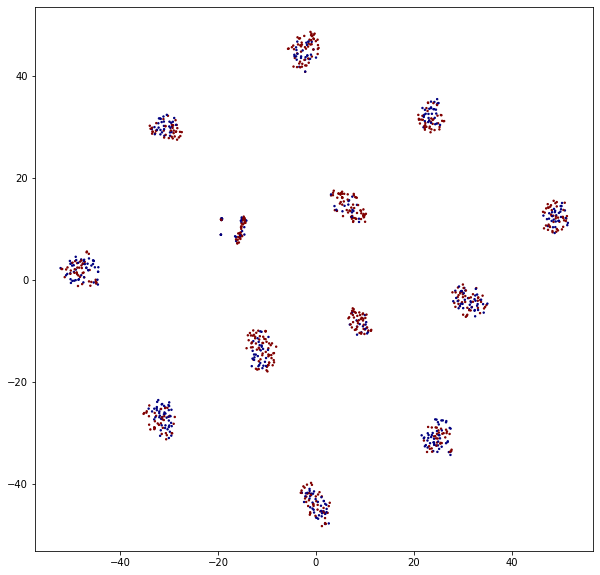

epoch: 15, test: loss_g: -0.0830 loss_g_ae: 0.0841 loss_g_clas: 1.6214 loss_d: 0.1374 loss_z_clas: 0.6603 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9717 accu_g: 0.8173 accu_g_gdy: 0.8170 accu_z_clas: 0.6036 bleu: 68.8100 equal: 0.1505 spam: 0.0001 bleu_remain: 62.4277 acc_remain: 0.9391


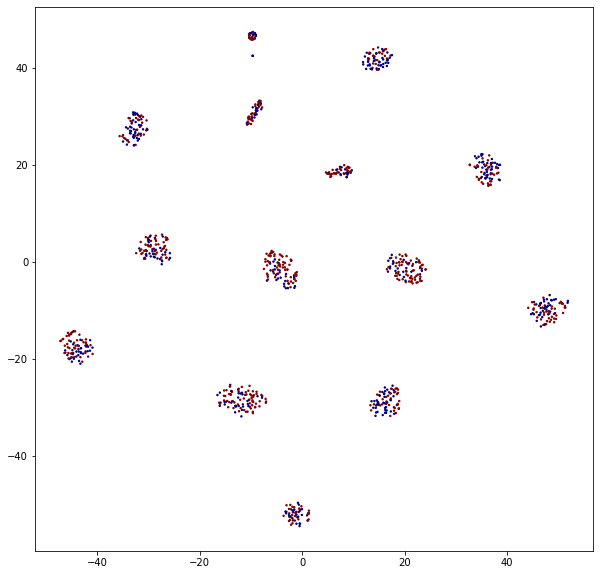

epoch: 15, manual: loss_g: -0.0167 loss_g_ae: 0.1081 loss_g_clas: 2.1132 loss_d: 0.1135 loss_z_clas: 0.6969 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9760 accu_g: 0.7740 accu_g_gdy: 0.7760 accu_z_clas: 0.5230 bleu: 71.6770 equal: 0.1670 spam: 0.0000 bleu_remain: 65.2920 acc_remain: 0.9162


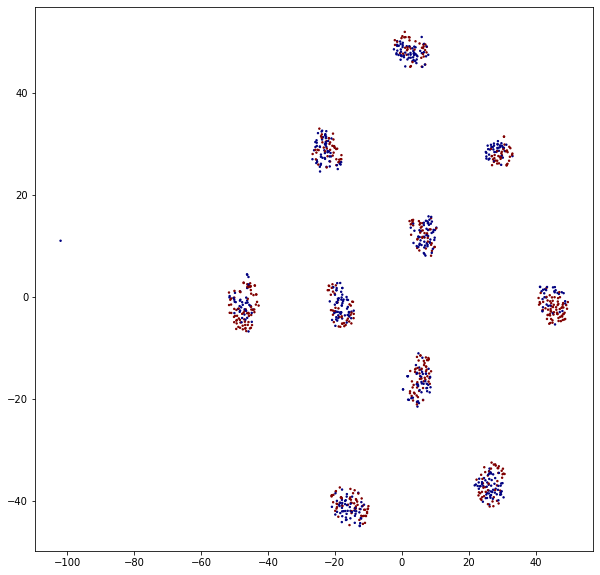

In [12]:
train_model()

In [13]:
print_result()

[['Input Sentence', 'Input Label', 'Generated Sentence', 'Predicted Label', 'BLEU'], ['we went home and then came back i think _num_ days later .', 0, 'we went home and then came back i think hilarious days later .', 0, 0.7611606003349892], ['i will definitely be back !', 1, 'i will might be back p.m.', 0, 0.8860807458582579], ['they kept things moving and on time during my visit .', 1, 'they kept things moving and on time during my visit .', 1, 1.0], ['however , after eating here for some time i had to stop .', 0, 'however , after eating here for some time i had to stop .', 0, 1.0], ['exceptionally yummy !', 1, 'exceptionally unsanitary p.m.', 0, 2.601015369737858], ['our bartender was very nice .', 1, 'our bartender was very nasty .', 0, 0.537284965911771], ['the views from the cafe are gorgeous !', 1, 'the views from the cafe are worse !', 0, 0.7071067811865475], ['i absolutely love their pizza !', 1, 'i absolutely skip their pizza p.m.', 0, 0.8860807458582579], ['professional and f